In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba
import statsmodels.api as sm
import pandas as pd

In [2]:
# Open NDSEV data
# ndsev = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ndsev/ndsev_1940-2024_mam.nc')['__xarray_dataarray_variable__'].load()
# ndsev_csonly = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ndsev/ndsev_cs_only_1940_2024_mam.nc')['__xarray_dataarray_variable__'].load()
# ndsev_nocin = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ndsev/ndsev_no_cin_1940-2024_mam.nc')['__xarray_dataarray_variable__'].load()

# ndsev_hoog = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ndsev/hoogewind_ndsev_mam_1940-2024.nc')['__xarray_dataarray_variable__'].load()
ndsev_diff = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ndsev/diff_trapp_ndsev_mam_1940-2024.nc')['__xarray_dataarray_variable__'].load()

In [3]:
# Subset the eastern US
# ndsev_east = ndsev.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
# ndsev_csonly_east = ndsev_csonly.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
# ndsev_nocin_east = ndsev_nocin.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))

# ndsev_hoog_east = ndsev_hoog.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
ndsev_diff_east = ndsev_diff.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
ndsev_diff_se = ndsev_diff.sel(longitude=slice(pdo_functions.convert_longitudes(-98), pdo_functions.convert_longitudes(-81))).sel(latitude=slice(38, 29))

NameError: name 'ndsev_diff_monthly' is not defined

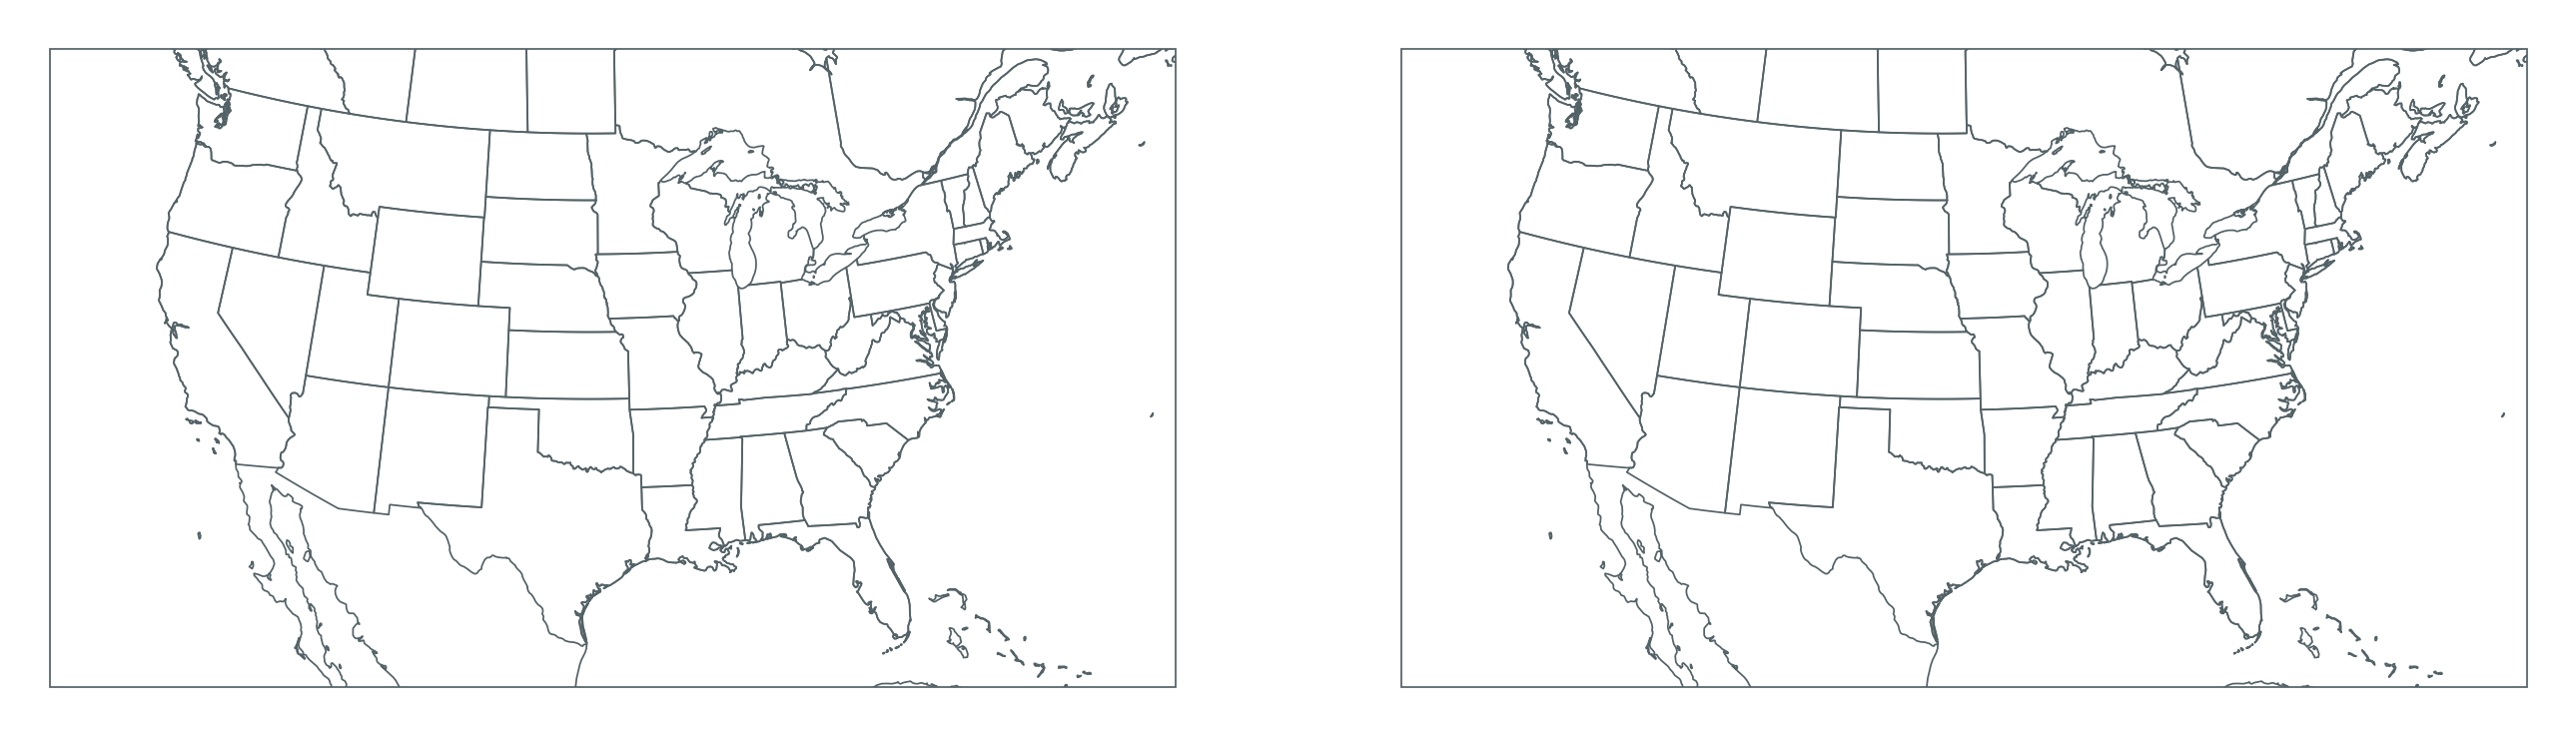

In [4]:
# Regions
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

bounds = np.arange(0, 42, 2)

norm = c.BoundaryNorm(bounds, plt.get_cmap('plasma').N)

for i in range(2):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, edgecolor='xkcd:gunmetal', lw=0.25)
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_extent([-125, -66.5, 24, 50], crs=ccrs.PlateCarree())

ax[0].pcolormesh(ndsev_diff_east['longitude'], ndsev_diff_east['latitude'], ndsev_diff_monthly.mean(axis=0), transform=ccrs.PlateCarree(), cmap='plasma', norm=norm)
ax[1].pcolormesh(ndsev_diff_se['longitude'], ndsev_diff_se['latitude'], ndsev_diff_monthly_se.mean(axis=0), transform=ccrs.PlateCarree(), cmap='plasma', norm=norm)

cax = plt.axes([0.05, .22, 0.9, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='plasma', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='max', \
                    ticks=[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40])
cbar.set_label(r'days MAM$^{-1}$', size=8, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].set_title('Central U.S.')
ax[1].set_title('Southeast U.S.')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.65, 
                    wspace=0.05, 
                    hspace=0.05)

In [5]:
# Summing NDSEV for each month
# ndsev_monthly = np.zeros((255, 65, 73))
# ndsev_csonly_monthly = np.zeros((255, 65, 73))
# ndsev_nocin_monthly = np.zeros((255, 65, 73))
# for i in range(85):
#     # Load in one year of data
#     ndsev_load = ndsev_east.isel(year=i).transpose('date', 'latitude', 'longitude').values
#     ndsev_csonly_load = ndsev_csonly_east.isel(year=i).transpose('date', 'latitude', 'longitude').values
#     ndsev_nocin_load = ndsev_nocin_east.isel(year=i).transpose('date', 'latitude', 'longitude').values

#     # Sum up NDSEV for MAR, APR, MAY, respectively
#     ndsev_monthly[i*3] = ndsev_load[0:31].sum(axis=0)
#     ndsev_monthly[i*3+1] = ndsev_load[31:61].sum(axis=0)
#     ndsev_monthly[i*3+2] = ndsev_load[61:].sum(axis=0)

#     ndsev_csonly_monthly[i*3] = ndsev_csonly_load[0:31].sum(axis=0)
#     ndsev_csonly_monthly[i*3+1] = ndsev_csonly_load[31:61].sum(axis=0)
#     ndsev_csonly_monthly[i*3+2] = ndsev_csonly_load[61:].sum(axis=0)

#     ndsev_nocin_monthly[i*3] = ndsev_nocin_load[0:31].sum(axis=0)
#     ndsev_nocin_monthly[i*3+1] = ndsev_nocin_load[31:61].sum(axis=0)
#     ndsev_nocin_monthly[i*3+2] = ndsev_nocin_load[61:].sum(axis=0)

#     # Progress
#     print(f'{1940+i} is complete.')

In [6]:
# Land masking
land_110 = regionmask.defined_regions.natural_earth_v4_1_0.land_110
east_land = xr.where(land_110.mask_3D(ndsev_diff_east)==True, 1, np.nan).squeeze()
se_land = xr.where(land_110.mask_3D(ndsev_diff_se)==True, 1, np.nan).squeeze()

In [7]:
np.shape(ndsev_diff_se)

(7820, 37, 69)

In [8]:
# Summing NDSEV for each month
# ndsev_hoog_monthly = np.zeros((85, 65, 73))
ndsev_diff_monthly = np.zeros((85, 65, 73))
ndsev_diff_monthly_se = np.zeros((85, 37, 69))
for i in range(85):
    ndsev_diff_monthly[i] = (ndsev_diff_east[i*92:(i+1)*92]*east_land).values.sum(axis=0)
    ndsev_diff_monthly_se[i] = (ndsev_diff_se[i*92:(i+1)*92]*se_land).values.sum(axis=0)


In [9]:
# Time array
months = pd.date_range('1940-03-01', '2025-01-01', freq='ME')
mam = months[months.month.isin([3, 4, 5])]

In [10]:
# Convert to XR
# ndsev_monthly_xr = xr.DataArray(ndsev_monthly, coords={'time':mam, 'latitude':ndsev_east['latitude'], 'longitude':ndsev_east['longitude']}, dims=['time', 'latitude', 'longitude'])
# ndsev_csonly_monthly_xr = xr.DataArray(ndsev_csonly_monthly, coords={'time':mam, 'latitude':ndsev_east['latitude'], 'longitude':ndsev_east['longitude']}, dims=['time', 'latitude', 'longitude'])
# ndsev_nocin_monthly_xr = xr.DataArray(ndsev_nocin_monthly, coords={'time':mam, 'latitude':ndsev_east['latitude'], 'longitude':ndsev_east['longitude']}, dims=['time', 'latitude', 'longitude'])

# ndsev_hoog_monthly_xr = xr.DataArray(ndsev_hoog_monthly, coords={'time':np.arange(1940, 2025, 1), 'latitude':ndsev_hoog_east['latitude'], 'longitude':ndsev_hoog_east['longitude']}, dims=['time', 'latitude', 'longitude'])

ndsev_diff_east_monthly_xr = xr.DataArray(ndsev_diff_monthly, coords={'time':np.arange(1940, 2025, 1), 'latitude':ndsev_diff_east['latitude'], 'longitude':ndsev_diff_east['longitude']}, dims=['time', 'latitude', 'longitude'])
ndsev_diff_se_monthly_xr = xr.DataArray(ndsev_diff_monthly_se, coords={'time':np.arange(1940, 2025, 1), 'latitude':ndsev_diff_se['latitude'], 'longitude':ndsev_diff_se['longitude']}, dims=['time', 'latitude', 'longitude'])

In [11]:
# ndsev_hoog_monthly_de = pdo_functions.detrend_dim(ndsev_hoog_monthly_xr, 'time', 2)
ndsev_diff_east_monthly_de = pdo_functions.detrend_dim(ndsev_diff_east_monthly_xr, 'time', 2)
ndsev_diff_se_monthly_de = pdo_functions.detrend_dim(ndsev_diff_se_monthly_xr, 'time', 2)

In [12]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1980, 2010)

nino_34 = pdo_functions.calc_nino_34_timeseries(sst, False, 1980, 2010)

In [13]:
# Standardize Nino3.4
# nino_34_std = (nino_34 - nino_34.mean()) / nino_34.std()

In [14]:
# 3- month rolling mean
nino_34_rolling = nino_34.rolling(time=3, center=True).mean()

nino_34_calc = np.zeros((1860))
for i in range(1860):
    if i < 5:
        continue
    else:
        if (nino_34_rolling[(i-4)] > 0.5) & (nino_34_rolling[(i-3)] > 0.5) & (nino_34_rolling[(i-2)] > 0.5) & (nino_34_rolling[(i-1)] > 0.5) & (nino_34_rolling[i] > 0.5):
            nino_34_calc[i] = 1
        elif (nino_34_rolling[(i-4)] < -0.5) & (nino_34_rolling[(i-3)] < -0.5) & (nino_34_rolling[(i-2)] < -0.5) & (nino_34_rolling[(i-1)] < -0.5) & (nino_34_rolling[i] < -0.5):
            nino_34_calc[i] = -1
        else:
            continue

# convert nino_34_calc to xr
nino_34_calc_xr = xr.DataArray(nino_34_calc, coords={'time':sst['time']}, dims=['time'])

# 1940-2024 only
nino_34_1940_2024 = nino_34_calc_xr.sel(time=nino_34_calc_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_1940_2024_mam = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5]))

In [15]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':nino_34['time']}, dims=['time'])

# Subset only 1940-2024
pdo_1940_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
# nino_34_1940_2024 = nino_34_std.sel(time=nino_34_std.time.dt.year.isin(np.arange(1940, 2025, 1)))

# only MAM
pdo_1940_2024_mam = pdo_1940_2024.sel(time=pdo_1940_2024.time.dt.month.isin([3, 4, 5])).groupby('time.year').mean()
# nino_34_1940_2024_mam = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5])).groupby('time.year').mean()

# Need to calculate when El Nino/La Nina Occurs in a given year
nino_34_1940_2024_mam_ann = np.zeros((85))
for i in range(85):
    if nino_34_1940_2024_mam[i*3:i*3+3].sum(axis=0) > 0:
        nino_34_1940_2024_mam_ann[i] = 1

    elif nino_34_1940_2024_mam[i*3:i*3+3].sum(axis=0) < 0:
        nino_34_1940_2024_mam_ann[i] = -1

    else:
        continue

In [17]:
# Weight and take spatial mean
weights_east = np.cos(np.deg2rad(ndsev_diff_east_monthly_de.latitude))
weights_se = np.cos(np.deg2rad(ndsev_diff_se_monthly_de.latitude))

ndsev_de_diff_east_ann_mean_wgt = ndsev_diff_east_monthly_de.weighted(weights_east).mean(dim=('latitude', 'longitude'))
ndsev_de_diff_se_ann_mean_wgt = ndsev_diff_se_monthly_de.weighted(weights_se).mean(dim=('latitude', 'longitude'))

In [18]:
window_weights = np.array([1, 3, 5, 3, 1])
window_weights = window_weights / window_weights.sum()

In [19]:
# Take rolling means
diff_east_5_rolling = ndsev_de_diff_east_ann_mean_wgt.rolling(time=5, center=True).mean()
diff_east_135_rolling = ndsev_de_diff_east_ann_mean_wgt.rolling(time=5, center=True).construct('window').dot(xr.DataArray(window_weights, dims='window'))
diff_east_11_rolling = ndsev_de_diff_east_ann_mean_wgt.rolling(time=11, center=True).mean()

diff_se_5_rolling = ndsev_de_diff_se_ann_mean_wgt.rolling(time=5, center=True).mean()
diff_se_135_rolling = ndsev_de_diff_se_ann_mean_wgt.rolling(time=5, center=True).construct('window').dot(xr.DataArray(window_weights, dims='window'))
diff_se_11_rolling = ndsev_de_diff_se_ann_mean_wgt.rolling(time=11, center=True).mean()

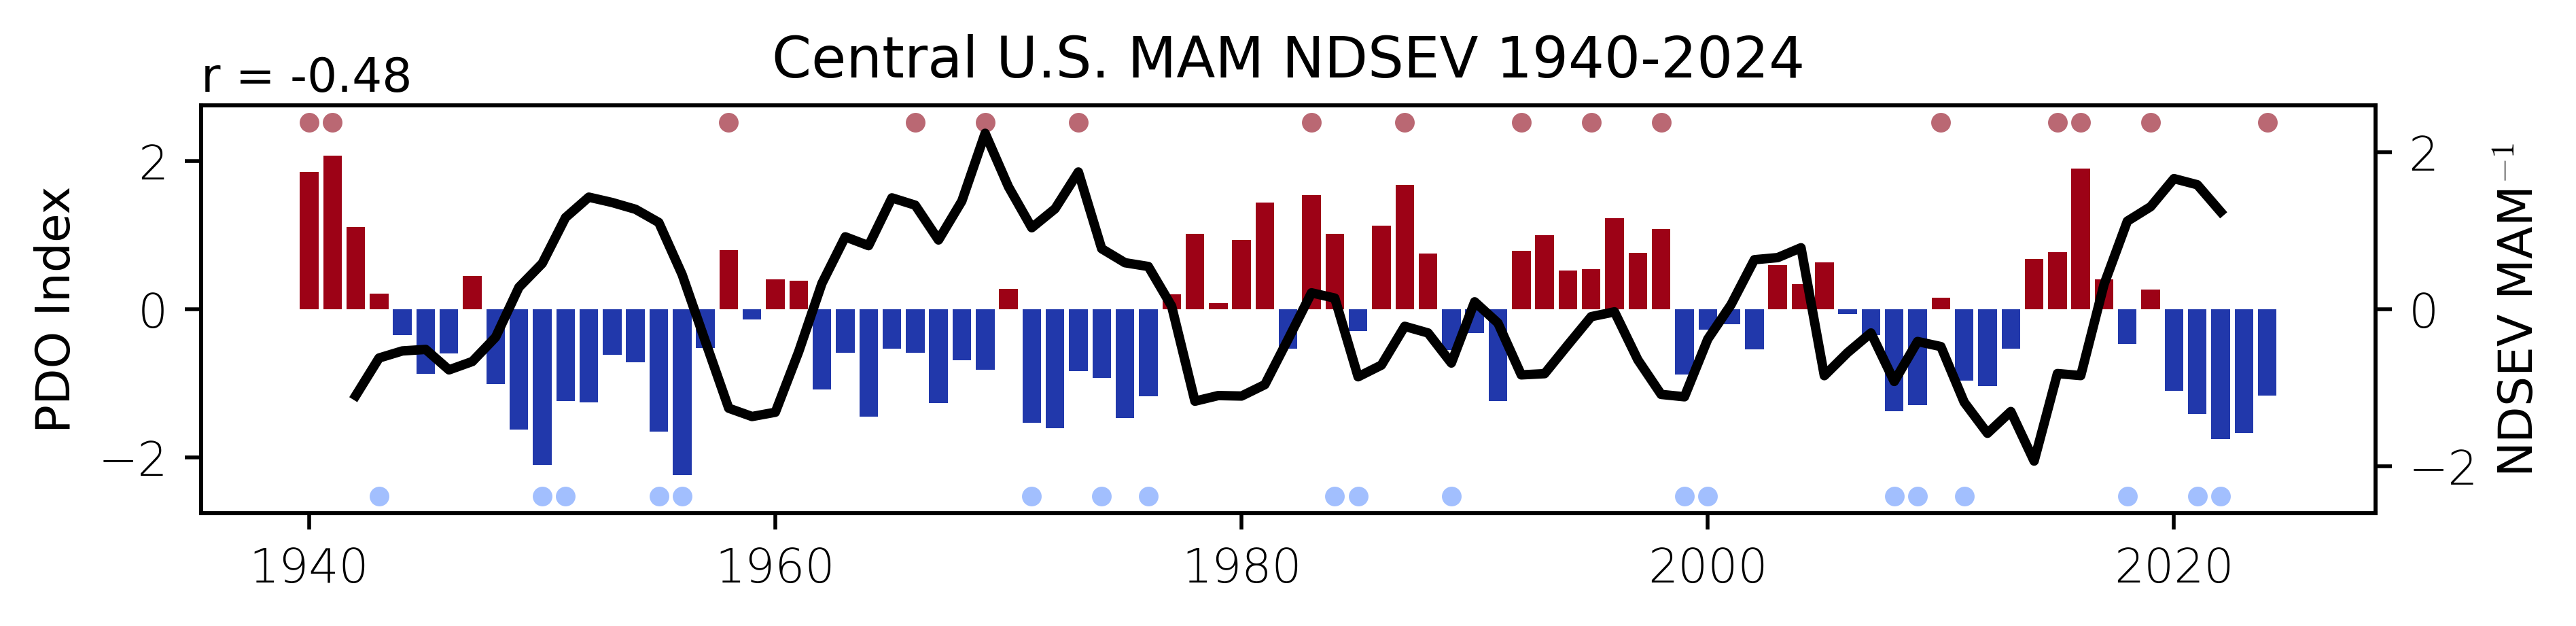

In [36]:
fig, ax = plt.subplots()

years = np.arange(1940, 2025, 1)

# for i in range(2):
ax.bar(years[pdo_1940_2024_mam > 0], pdo_1940_2024_mam[pdo_1940_2024_mam > 0], color='xkcd:carmine')
ax.bar(years[pdo_1940_2024_mam < 0], pdo_1940_2024_mam[pdo_1940_2024_mam < 0], color='xkcd:sapphire')
ax.set_ylim(-2.75, 2.75)
ax.set_ylabel('PDO Index', fontsize=10)
ax.scatter(years[nino_34_1940_2024_mam_ann > 0], nino_34_1940_2024_mam_ann[nino_34_1940_2024_mam_ann > 0]*2.52, s=40, color='xkcd:dusky rose', marker='.')
ax.scatter(years[nino_34_1940_2024_mam_ann < 0], nino_34_1940_2024_mam_ann[nino_34_1940_2024_mam_ann < 0]*2.52, s=40, color='xkcd:pastel blue', marker='.')

ax2 = ax.twinx()
ax2.plot(years, diff_east_5_rolling, color='black', lw=2)
ax2.set_ylim(-2.6, 2.6)
ax2.set_ylabel('NDSEV MAM$^{-1}$', fontsize=10)
ax2.set_title('Central U.S. MAM NDSEV 1940-2024')

ax.set_title(f'r = {-0.48}', loc='left', pad=3, fontsize=10)
# ax3 = ax[1].twinx()
# ax3.plot(years, diff_se_5_rolling, color='black', lw=2)
# ax3.set_ylim(-4.1, 4.1)
# ax3.set_ylabel('days MAM$^{-1}$')
# ax3.set_title('Southeast U.S. MAM NDSEV 1940-2024')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.5, 
                    wspace=0.05, 
                    hspace=0.4)